### 05 AI Agent Workflow + RAG（検索拡張生成）
gpt-oss:20bを使用する構成のため、**Colab GPU は L4 を使用すること。**
- 必要なライブラリをインストール
- Google Colab に Ollama をセットアップ
  - LLM モデルは gpt-oss:20b を使用（Ollama）
  - Embedding モデルは ruri-v3-310m を使用（Sentence Transformers）
  - Reranker モデルは cl-nagoya/ruri-v3-reranker-310m を使用（Sentence Transformers）
- JAXA（宇宙航空研究開発機構）のリポジトリからデータをダウンロードして読み込み
> [井澤克彦, 市川信一郎, 高速回転ホイール: 高速回転ホイール開発を通しての知見, 宇宙航空研究開発機構研究開発報告, 2008](https://jaxa.repo.nii.ac.jp/records/2149)
- データの前処理
  - markdown に変換（MarkItDown を使用）
  - Unicode正規化 (NFKC), 1文字行ブロックの除去, 空行圧縮
  - チャンク分割
    - LangChain の SpacyTextSplitter を使用
    - spaCy の日本語モデルは、ja_ginza を使用
- ベクトルデータベースの構築（ChromaDB, インメモリ）
- 検索機能の実装
  - キーワード検索 @ BM25（spaCyで形態素解析の前処理が必要）
  - Embedding model によるセマンティック検索
  - ハイブリッド検索
  - Reranker による再順位付け
  - 検索機能をLLM の tool として定義
- LangGraph による Workflow の実装
  1. ユーザの質問を入力。
  2. ユーザの質問に回答するためのタスク分割, 作成。
  3. tool による検索。
  4. tool による検索を終えて回答作成に進むか判断。再調査なら 3 に戻る。
  5. ユーザへの回答の作成と提示。
- 動作確認

**必要なライブラリをインストール**

In [1]:
# Google Colab に必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
# NOTE: langchain 関連は 1.x 系に明示的に指定する。
#       Colab プリインストールの 0.3.x が残ると langchain-mcp-adapters が動作しない。
# Pythonのリストとして定義することで、Pylanceの警告を防ぎ、可読性を高める。

# fmt: off
pkgs = [
    "ollama", "langchain-ollama",
    "langchain>=1.2.8", "langchain-core>=1.2.8", "langgraph>=1.0.7",
    "markitdown[all]", "chromadb", "langchain-text-splitters>=0.3",
    "spacy", "ginza", "ja-ginza", "rank-bm25",
    "sentence-transformers",
]
# fmt: on

# リストを結合して pip に渡す
# magic command内で {変数} を使うと展開される機能を利用
%pip install -U -q {" ".join(pkgs)}

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-exporter-otlp-proto-http 1.38.0 requires opentelemetry-exporter-otlp-proto-common==1.38.0, but you have opentelemetry-exporter-otlp-proto-common 1.39.1 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.38.0 requires opentelemetry-proto==1.38.0, but you have opentelemetry-proto 1.39.1 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.38.0 requires opentelemetry-sdk~=1.38.0, but you have opentelemetry-sdk 1.39.1 which is incompatible.
opentelemetry-exporter-gcp-logging 1.11.0a0 requires opentelemetry-sdk<1.39.0,>=1.35.0, but you have opentelemetry-sdk 1.39.1 which is incompatible.


**Google Colab に Ollama をセットアップ**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [2]:
# Ollama のインストール・起動・モデルのダウンロード
# 詳細は 01_connect_oss_llm.ipynb を参照
import subprocess
import time
import ollama  # type: ignore

!apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh

process = subprocess.Popen(
    ["ollama", "serve"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)


def ollama_pull(model: str) -> None:
    """Ollama モデルをダウンロードし、進捗をインライン表示する。"""
    for progress in ollama.pull(model, stream=True):
        status = progress.get("status", "")
        total = progress.get("total") or 0
        completed = progress.get("completed") or 0
        if total:
            line = f"{status}: {completed / total:.0%}"
        else:
            line = status
        print(f"\r{line:<60}", end="", flush=True)
    print(f"\n{model}: Done!")


model_name = "gpt-oss:20b"
ollama_pull(model_name)
!ollama show {model_name}

Selecting previously unselected package zstd.
(Reading database ... 121852 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
success                                                     
gpt-oss:20b: Done!
  Model
    architecture        gptoss    
    parameters          20.9B     
    context length      131072    
    embedding length    2880      
    quantization        MXFP4     

  Ca

**ChatOllama で LLM に接続**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [ ]:
# ChatOllama で LLM に接続する。
from langchain_ollama import ChatOllama  # type: ignore

llm = ChatOllama(
    model="gpt-oss:20b",
    num_ctx=16384,
    num_predict=-1,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    repeat_penalty=1.1,
    reasoning="medium",  # gpt-oss は 'low'/'medium'/'high' のみ受け付ける
)

**Embedding モデル（ruri-v3-310m）と Reranker モデルのセットアップ**
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [4]:
# Embedding: ruri-v3-310m (Sentence Transformers 経由)
from langchain_core.embeddings import Embeddings  # type: ignore
from sentence_transformers import SentenceTransformer, CrossEncoder  # type: ignore


class RuriEmbeddings(Embeddings):
    """ruri-v3 を LangChain の Embeddings インターフェースでラップする。"""

    def __init__(self, model_name: str = "cl-nagoya/ruri-v3-310m") -> None:
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        prefixed = [f"検索文書: {t}" for t in texts]
        return self.model.encode(prefixed).tolist()

    def embed_query(self, text: str) -> list[float]:
        return self.model.encode(f"検索クエリ: {text}").tolist()


embeddings = RuriEmbeddings()
test_vec = embeddings.embed_query("テスト文です")
print(f"Embedding dim: {len(test_vec)}")

# Reranker: cl-nagoya/ruri-v3-reranker-310m
reranker = CrossEncoder("cl-nagoya/ruri-v3-reranker-310m")
print("Reranker model loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/152 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Embedding dim: 768


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/156 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Reranker model loaded.


**JAXA リポジトリからデータをダウンロード → 前処理 → チャンク分割**
> [井澤克彦, 市川信一郎, 高速回転ホイール: 高速回転ホイール開発を通しての知見, 宇宙航空研究開発機構研究開発報告, 2008](https://jaxa.repo.nii.ac.jp/records/2149)
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [5]:
# JAXA リポジトリから PDF をダウンロードし、MarkItDown で markdown に変換する。
import urllib.request
import unicodedata
import re
from pathlib import Path
from markitdown import MarkItDown  # type: ignore

pdf_url = "https://jaxa.repo.nii.ac.jp/record/2149/files/63826000.pdf"
pdf_path = Path("高速回転ホイール.pdf")

if not pdf_path.exists():
    urllib.request.urlretrieve(pdf_url, pdf_path)
    print(f"ダウンロード完了: {pdf_path}")

md = MarkItDown()
result = md.convert(str(pdf_path))
raw_text = result.text_content
print(f"変換後の文字数: {len(raw_text)}")

# Unicode 正規化 (NFKC)
text = unicodedata.normalize("NFKC", raw_text)


# PDF 抽出テキストの汎用クリーニング
def clean_pdf_text(text: str) -> str:
    """1文字行ブロックの除去 + 空行圧縮。"""
    text = re.sub(
        r"(^[^\S\n]*\S[^\S\n]*$\n?){3,}",
        "\n",
        text,
        flags=re.MULTILINE,
    )
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()


text = clean_pdf_text(text)
print(f"クリーニング後の文字数: {len(text)}")

ダウンロード完了: 高速回転ホイール.pdf
変換後の文字数: 86888
クリーニング後の文字数: 79515


**notebook 04 からの変更点**
- `CHUNK_SIZE` ：1500 から 500 に変更
- `CHUNK_OVERLAP` ：300 から 100 に変更
> チャンクサイズが大きく、かつ、この Workflow だと複数回検索することにより、LLM のコンテキスト長不足になることが想定されるため。チャンクサイズを小さく取り、複数回の検索によって、重要な情報のみを、ピンポイントでデータから抽出することを意図している。

In [6]:
# SpacyTextSplitter でチャンク分割する。
# Sudachi の入力上限 (49,149 bytes) を超えないように事前分割してから渡す。
from langchain_text_splitters import SpacyTextSplitter  # type: ignore

CHUNK_SIZE = 500
CHUNK_OVERLAP = 100
BLOCK_MAX_BYTES = 40_000
BLOCK_OVERLAP_CHARS = CHUNK_SIZE


def split_into_safe_blocks(
    text: str,
    max_bytes: int = BLOCK_MAX_BYTES,
    overlap_chars: int = BLOCK_OVERLAP_CHARS,
) -> list[str]:
    """テキストを段落区切りで max_bytes 以下のブロックに分割する。"""
    paragraphs = text.split("\n\n")
    blocks: list[str] = []
    current = ""
    for para in paragraphs:
        candidate = current + "\n\n" + para if current else para
        if len(candidate.encode("utf-8")) > max_bytes and current:
            blocks.append(current)
            current = current[-overlap_chars:] + "\n\n" + para
        else:
            current = candidate
    if current:
        blocks.append(current)
    return blocks


text_splitter = SpacyTextSplitter(
    separator="\n\n",
    pipeline="ja_ginza",
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
)

blocks = split_into_safe_blocks(text)
chunks: list[str] = []
for block in blocks:
    chunks.extend(text_splitter.split_text(block))

print(f"チャンク数: {len(chunks)}")

チャンク数: 214


**ベクトルデータベースの構築（ChromaDB, インメモリ）**
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [7]:
# ChromaDB にチャンクを格納する（インメモリ）。
import chromadb  # type: ignore

chroma_client = chromadb.Client()

collection = chroma_client.create_collection(
    name="jaxa_wheel",
    metadata={"hnsw:space": "cosine"},
)

chunk_embeddings = embeddings.embed_documents(chunks)

collection.add(
    ids=[f"chunk_{i}" for i in range(len(chunks))],
    documents=chunks,
    embeddings=chunk_embeddings,
)

print(f"ChromaDB に {collection.count()} 件のチャンクを格納しました。")

ChromaDB に 214 件のチャンクを格納しました。


**検索機能の実装（BM25 + セマンティック + ハイブリッド + Reranker）と tool 定義**
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [8]:
# BM25 用の前処理: spaCy (ja_ginza) で形態素解析してトークン化する。
import numpy as np  # type: ignore
import spacy  # type: ignore
from rank_bm25 import BM25Okapi  # type: ignore

nlp = spacy.load("ja_ginza", disable=["parser", "ner"])


def tokenize(text: str) -> list[str]:
    """spaCy で形態素解析し、BM25 用のトークンリストを返す。"""
    doc = nlp(text)
    tokens = []
    include_pos = {"NOUN", "VERB", "ADJ", "PROPN", "NUM"}
    for token in doc:
        if token.pos_ not in include_pos:
            continue
        if token.is_stop:
            continue
        lemma = token.lemma_
        if len(lemma) == 1 and re.match(r"[ぁ-ん\u30fc!-/:-@\[-`{-~]", lemma):
            continue
        tokens.append(lemma)
    return tokens


tokenized_chunks = [tokenize(chunk) for chunk in chunks]
bm25 = BM25Okapi(tokenized_chunks)
print(f"BM25 インデックス構築完了: {len(tokenized_chunks)} 件")

BM25 インデックス構築完了: 214 件


In [9]:
# 検索関数の定義（BM25, セマンティック, ハイブリッド, Reranker）
RETRIEVAL_TOP_K = 20
RERANK_TOP_K = 5
BM25_WEIGHT = 0.3


def search_bm25(query: str, top_k: int = RETRIEVAL_TOP_K) -> list[dict]:
    """BM25 によるキーワード検索を行う。"""
    tokenized_query = tokenize(query)
    scores = bm25.get_scores(tokenized_query)
    top_indices = np.argsort(scores)[::-1][:top_k]
    return [
        {
            "rank": rank + 1,
            "chunk_id": int(idx),
            "score": float(scores[idx]),
            "text": chunks[idx],
        }
        for rank, idx in enumerate(top_indices)
        if scores[idx] > 0
    ]


def search_semantic(query: str, top_k: int = RETRIEVAL_TOP_K) -> list[dict]:
    """Embedding model によるセマンティック検索を行う。"""
    query_embedding = embeddings.embed_query(query)
    results = collection.query(query_embeddings=[query_embedding], n_results=top_k)
    return [
        {
            "rank": rank + 1,
            "chunk_id": int(doc_id.split("_")[1]),
            "score": 1.0 - dist,
            "text": doc,
        }
        for rank, (doc_id, doc, dist) in enumerate(
            zip(results["ids"][0], results["documents"][0], results["distances"][0])
        )
    ]


def search_hybrid(
    query: str, top_k: int = RETRIEVAL_TOP_K, bm25_weight: float = BM25_WEIGHT
) -> list[dict]:
    """BM25 とセマンティック検索の RRF ハイブリッド検索を行う。"""
    k = 60
    bm25_results = search_bm25(query, top_k=top_k)
    semantic_results = search_semantic(query, top_k=top_k)

    scores: dict[int, float] = {}
    texts: dict[int, str] = {}

    for r in bm25_results:
        cid = r["chunk_id"]
        scores[cid] = scores.get(cid, 0) + bm25_weight / (k + r["rank"])
        texts[cid] = r["text"]

    semantic_weight = 1.0 - bm25_weight
    for r in semantic_results:
        cid = r["chunk_id"]
        scores[cid] = scores.get(cid, 0) + semantic_weight / (k + r["rank"])
        texts[cid] = r["text"]

    sorted_ids = sorted(scores, key=lambda cid: scores[cid], reverse=True)[:top_k]
    return [
        {"rank": rank + 1, "chunk_id": cid, "score": scores[cid], "text": texts[cid]}
        for rank, cid in enumerate(sorted_ids)
    ]


def rerank(query: str, results: list[dict], top_k: int = RERANK_TOP_K) -> list[dict]:
    """Reranker (CrossEncoder) で検索結果を再順位付けする。"""
    if not results:
        return []
    pairs = [(query, r["text"]) for r in results]
    scores = reranker.predict(pairs)
    ranked_indices = np.argsort(scores)[::-1][:top_k]
    return [
        {
            "rank": rank + 1,
            "chunk_id": results[idx]["chunk_id"],
            "score": float(scores[idx]),
            "text": results[idx]["text"],
        }
        for rank, idx in enumerate(ranked_indices)
    ]


print("検索関数を定義しました: search_bm25, search_semantic, search_hybrid, rerank")

検索関数を定義しました: search_bm25, search_semantic, search_hybrid, rerank


In [10]:
# 検索機能を LLM の tool として定義する。
from langchain_core.tools import tool  # type: ignore

MAX_RETURN_CHARS = 8000


@tool
def search_document(query: str) -> str:
    """外部ナレッジベースから、クエリに関連する情報を検索・取得します。
    ユーザーの質問に対し、具体的な事実、データ、あるいは詳細な文脈が必要な場合、
    自身の知識だけで回答せずに必ずこのツールを使用してください。

    Args:
        query: 検索したい内容を表す、具体的かつ完全な文章（日本語）。
    """
    try:
        hybrid_results = search_hybrid(query)
        reranked = rerank(query, hybrid_results)
    except Exception as e:
        return f"検索中にエラーが発生しました: {e}"

    if not reranked:
        return "検索結果が見つかりませんでした。"

    passages = []
    total_chars = 0
    for r in reranked:
        passage = f"[チャンク {r['chunk_id']}] (スコア: {r['score']:.4f})\n{r['text']}"
        total_chars += len(passage)
        if total_chars > MAX_RETURN_CHARS:
            break
        passages.append(passage)
    return "\n\n---\n\n".join(passages)


search_tool = search_document
print(f"RAG Tool: {search_tool.name}")

RAG Tool: search_document


**LangGraph による Workflow の実装**

03_02 の Workflow を RAG 検索用に適応する。web_search ノードを doc_search ノードに置き換え、
MCP サーバの代わりに `search_document` ツールで検索する。
- 詳細は [03_02_AI_Agent_Workflow.ipynb](03_02_AI_Agent_Workflow.ipynb) を参照。

**Workflow の流れ**
1. **task_planning**: ユーザの質問を受け取り、回答に必要なサブタスク（目的＋検索クエリ）を構造化して作成する。
2. **doc_search**: 各サブタスクの検索クエリを `search_document` ツールで実行し、目的と紐付けた検索結果を蓄積する。
3. **judge**: サブタスクの目的ごとに、検索結果が十分かを LLM が判断する。不足なら追加サブタスクを生成して doc_search に戻る。
4. **generate_answer**: 目的ごとに整理された検索結果をもとに、ユーザの質問に対する最終回答を生成する。

**Pydantic / with_structured output による構造化出力**

検索結果に LaTeX 数式が含まれるなどの場合、LLM の出力が引きずられて、notebook 03_02 の JSONパース（自作した `extract_json_text` ）関数が機能しない場合があった。このため、Pydantic / with_structured output による構造化出力によって、望ましい出力を LLM に強制させる。

<u>使い方<u/>
- `queries: list[str] = Field(description="検索クエリのリスト")` では、LLM が出力するデータ型を、`list[str]` で規定し、LLM に出力させたい `str` の内容を、`Field(description=" ")` で規定する。
- 入れ子にもできる。 `subtasks: list[Subtask] = Field(description="サブタスクのリスト（最大3個）")` では、`list` の型を、`class Subtask(BaseModel)` として規定している。
- 以下では、`list[Subtask]` か、`None` のどちらかの型であれば良いという指示になる。コードとしては、`sufficient = True` で `None` 、` = False` で、`list[Subtask]` となることを期待しており、LLM がそのような選択をすることを期待した `description` を設定している。
`
sufficient: bool = Field(description="情報が十分かどうか")
    reason: str = Field(description="判断理由を日本語で1文で")
    additional_subtasks: list[Subtask] | None = Field(
        default=None,
        description="不足時の追加サブタスク",
    )
`
> しかし、上記の場合、動作の安定性が LLM 任せとなってしまうので、`@model_validator(mode="after")` で、LLM の出力を強制的に固定するようにしている。（`sufficient = True` なら必ず `None`、` = False` なのに、`additional_subtasks` が空の場合は、エラー出力をした上、`sufficient = True` + `None` に設定する。

In [11]:
# Workflow の状態定義・Pydantic モデル・システムプロンプト
from typing import TypedDict
from pydantic import BaseModel, Field, model_validator  # type: ignore
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore
from langgraph.graph import StateGraph, START, END  # type: ignore
from IPython.display import Image, display

# --- グローバル設定 ---
MAX_LOOP_COUNT = 2  # judge → doc_search 再調査ループの上限回数


# --- Workflow の状態 ---
class WorkflowState(TypedDict):
    question: str
    subtasks: list[dict]  # [{"purpose": str, "queries": [str]}]
    search_results: list[str]  # 目的と紐付けた検索結果
    answer: str
    loop_count: int


# --- with_structured_output 用の Pydantic モデル ---
class Subtask(BaseModel):
    purpose: str = Field(description="このサブタスクで明らかにしたいこと")
    queries: list[str] = Field(description="検索クエリのリスト")


class TaskPlanningResult(BaseModel):
    subtasks: list[Subtask] = Field(description="サブタスクのリスト（最大3個）")


class JudgeResult(BaseModel):
    sufficient: bool = Field(description="情報が十分かどうか")
    reason: str = Field(description="判断理由を日本語で1文で")
    additional_subtasks: list[Subtask] | None = Field(
        default=None,
        description="不足時の追加サブタスク",
    )

    @model_validator(mode="after")
    def force_consistency(self):
        """LLM 出力の論理矛盾を自動補正する。"""
        # 十分なのにタスクがある → タスクを破棄
        if self.sufficient:
            self.additional_subtasks = None

        # 不足なのにタスクがない → 十分と見なして回答生成へ強制移行
        if not self.sufficient and not self.additional_subtasks:
            print(
                "【自動補正】情報不足と判定されましたが、"
                "追加タスクが空のため、回答生成へ強制移行します。"
            )
            self.sufficient = True
            self.reason += (
                " (※追加調査事項が具体化できなかったため、現状の情報で回答します)"
            )
            self.additional_subtasks = None

        return self


# --- 各ノードのシステムプロンプト ---
SYSTEM_PROMPT_TASK_PLANNING = """\
あなたはリサーチプランナーです。
ユーザの質問に回答するために、ナレッジベース（技術文書）を検索するためのサブタスクを作成してください。

サブタスクは最大3個までとしてください。
purpose は判定ステップで「この目的に十分な情報が得られたか」を評価する基準になります。
具体的かつ明確に書いてください。
検索クエリは、技術文書から関連情報を検索するための日本語の具体的なフレーズにしてください。
"""

SYSTEM_PROMPT_JUDGE = """\
あなたはリサーチの品質を判定する審査員です。
ユーザの質問と検索結果を見て、回答に十分な情報があるか判断してください。
検索結果には【目的: ...】タグが付いています。
各目的について十分な情報が得られているかを確認してください。

sufficient が true なら回答作成に進みます。
sufficient が false なら、不足している目的について additional_subtasks を生成してください。
"""

SYSTEM_PROMPT_GENERATE_ANSWER = """\
あなたはリサーチ結果をもとに回答するAIアシスタントです。
検索結果を参考に、ユーザの質問に日本語で丁寧に回答してください。
回答は必ず検索結果に基づいて作成し、検索結果に含まれない情報は含めないでください。
回答の最後に、以下の形式で結論をまとめてください。

# 結論
- ユーザの質問: （質問内容）
- 回答: （簡潔な回答）
"""

print("Workflow の状態定義・Pydantic モデル・システムプロンプトを定義しました。")

Workflow の状態定義・Pydantic モデル・システムプロンプトを定義しました。


In [12]:
# Workflow ノードの定義

# ノード 1: task_planning（タスク分割）— with_structured_output で JSON 出力を強制
async def task_planning(state: WorkflowState) -> dict:
    """ユーザの質問を分析し、サブタスク（目的＋検索クエリ）を作成する。"""
    question = state["question"]
    structured_llm = llm.with_structured_output(TaskPlanningResult)

    try:
        result = await structured_llm.ainvoke(
            [
                SystemMessage(content=SYSTEM_PROMPT_TASK_PLANNING),
                HumanMessage(content=question),
            ]
        )
        subtasks = [st.model_dump() for st in result.subtasks]
    except Exception as e:
        print(f"[task_planning] 構造化出力失敗 → フォールバック: {e}")
        subtasks = [{"purpose": "基本調査", "queries": [question]}]

    print(f"[task_planning] サブタスク数: {len(subtasks)}")
    for i, st in enumerate(subtasks):
        print(f"  {i + 1}. 目的: {st['purpose']}")
        print(f"     クエリ: {st['queries']}")
    return {"subtasks": subtasks, "search_results": [], "loop_count": 0}


# ノード 2: doc_search（ドキュメント検索）
async def doc_search(state: WorkflowState) -> dict:
    """各サブタスクの検索クエリを search_document ツールで実行し、結果を蓄積する。"""
    subtasks = state["subtasks"]
    results = list(state.get("search_results") or [])

    for st in subtasks:
        purpose = st["purpose"]
        print(f"[doc_search] 目的: {purpose}")
        for query in st["queries"]:
            print(f"  検索中: {query}")
            try:
                result = search_tool.invoke({"query": query})
            except Exception as e:
                print(f"  [ERROR] クエリ失敗: {query} → {e}")
                continue
            if not result or result == "検索結果が見つかりませんでした。":
                print(f"  [SKIP] 検索結果なし: {query}")
                continue
            results.append(f"【目的: {purpose}】\n【クエリ: {query}】\n{result}")

    return {"search_results": results, "subtasks": []}


# ノード 3: judge（判定）— with_structured_output で JSON 出力を強制
async def judge(state: WorkflowState) -> dict:
    """検索結果が十分かを判断し、不足なら追加サブタスクを生成する。"""
    question = state["question"]
    results = state["search_results"]
    loop_count = state.get("loop_count", 0)

    if loop_count >= MAX_LOOP_COUNT:
        print("[judge] ループ上限に到達 → 回答作成へ")
        return {"subtasks": [], "loop_count": loop_count}

    results_text = "\n\n".join(results)
    structured_llm = llm.with_structured_output(JudgeResult)

    try:
        judgment = await structured_llm.ainvoke(
            [
                SystemMessage(content=SYSTEM_PROMPT_JUDGE),
                HumanMessage(content=f"質問: {question}\n\n検索結果:\n{results_text}"),
            ]
        )
    except Exception as e:
        print(f"[judge] 構造化出力失敗 → 回答作成へ: {e}")
        return {"subtasks": [], "loop_count": loop_count + 1}

    reason = judgment.reason

    if judgment.sufficient:
        print(f"[judge] 情報十分 → 回答作成へ（理由: {reason}）")
        return {"subtasks": [], "loop_count": loop_count + 1}
    else:
        additional = [st.model_dump() for st in (judgment.additional_subtasks or [])]
        print(f"[judge] 情報不足（理由: {reason}）→ 追加サブタスク:")
        for i, st in enumerate(additional):
            print(f"  {i + 1}. 目的: {st.get('purpose', '?')}")
            print(f"     クエリ: {st.get('queries', [])}")
        return {"subtasks": additional, "loop_count": loop_count + 1}


# ルーター: judge の結果で分岐
def should_continue_search(state: WorkflowState) -> str:
    """追加サブタスクがあれば doc_search に戻り、なければ回答生成へ。"""
    if state.get("subtasks"):
        return "doc_search"
    return "generate_answer"


# ノード 4: generate_answer（回答生成）
async def generate_answer(state: WorkflowState) -> dict:
    """蓄積した検索結果をもとに最終回答を生成する。"""
    question = state["question"]
    results_text = "\n\n".join(state["search_results"])

    response = await llm.ainvoke(
        [
            SystemMessage(content=SYSTEM_PROMPT_GENERATE_ANSWER),
            HumanMessage(content=f"質問: {question}\n\n検索結果:\n{results_text}"),
        ]
    )

    answer = response.content or ""

    if not answer:
        print("[generate_answer] WARNING: response.content が空です")
        print(f"  response type: {type(response)}")
        print(f"  response repr: {repr(response)[:500]}")

    print("[generate_answer] 回答生成完了")
    return {"answer": answer}


print(
    "Workflow ノードを定義しました: task_planning, doc_search, judge, generate_answer"
)

Workflow ノードを定義しました: task_planning, doc_search, judge, generate_answer


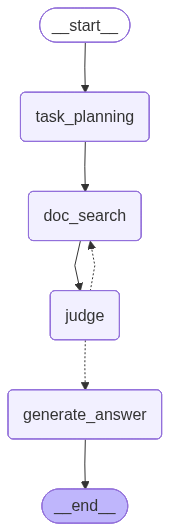

In [13]:
# Workflow グラフの構築とコンパイル
workflow = StateGraph(WorkflowState)

# ノードの登録
workflow.add_node("task_planning", task_planning)
workflow.add_node("doc_search", doc_search)
workflow.add_node("judge", judge)
workflow.add_node("generate_answer", generate_answer)

# エッジの定義
workflow.add_edge(START, "task_planning")
workflow.add_edge("task_planning", "doc_search")
workflow.add_edge("doc_search", "judge")

# 条件分岐: judge → doc_search（再調査） or generate_answer（回答生成）
workflow.add_conditional_edges(
    "judge",
    should_continue_search,
    {
        "doc_search": "doc_search",
        "generate_answer": "generate_answer",
    },
)
workflow.add_edge("generate_answer", END)

# コンパイル
app = workflow.compile()

# グラフの可視化
display(Image(app.get_graph().draw_mermaid_png()))

**動作確認**

In [14]:
# Workflow エージェントの動作確認
import io
import sys
from IPython.display import Markdown, HTML, display

# 中間ログをキャプチャしつつ、リアルタイムでもセルに出力する
log_buffer = io.StringIO()


class TeeStream:
    """stdout への出力を画面表示しつつバッファにも記録する。"""

    def __init__(self, original, buffer):
        self.original = original
        self.buffer = buffer

    def write(self, text):
        self.original.write(text)
        self.buffer.write(text)

    def flush(self):
        self.original.flush()


_original_stdout = sys.stdout
sys.stdout = TeeStream(_original_stdout, log_buffer)
try:
    result = await app.ainvoke(
        {"question": "高速回転ホイールの寿命試験ではどのような結果が得られましたか？"}
    )
finally:
    sys.stdout = _original_stdout

# 中間ログを HTML で全文表示（Colab のセル出力トランケートを回避）
log_text = log_buffer.getvalue()
print("\n--- 以下は HTML による全文ログ（トランケート回避） ---")
display(HTML(f"<pre style='white-space:pre-wrap'>{log_text}</pre>"))

# 最終回答の表示
print("=== Workflow エージェントの実行結果 ===\n")
answer = result.get("answer", "")
if answer:
    display(Markdown(answer))
else:
    print("[WARNING] 回答が空です。result keys:", list(result.keys()))
    print("search_results 件数:", len(result.get("search_results", [])))
    print("loop_count:", result.get("loop_count"))

[task_planning] サブタスク数: 3
  1. 目的: 高速回転ホイールの寿命試験に関する実験データや結論が掲載されている技術文書を特定する。
     クエリ: ['高速回転ホイール 寿命試験 報告書', '高速回転ホイール 寿命 試験 結果', '高速回転ホイール 破壊解析 報告']
  2. 目的: 特定した文書から、寿命試験の主要な結果（試験条件、破壊モード、サイクル数、残存寿命評価など）を抜粋し、整理する。
     クエリ: ['高速回転ホイール 試験 条件 破壊モード', '高速回転ホイール サイクル数 寿命', '高速回転ホイール 破壊原因']
  3. 目的: 抜粋した情報を統合し、試験結果の総括（成功・失敗要因、設計改善提案、今後の研究課題）をまとめる。
     クエリ: ['高速回転ホイール 試験 結果 まとめ', '高速回転ホイール 寿命 改善提案', '高速回転ホイール 研究課題']
[doc_search] 目的: 高速回転ホイールの寿命試験に関する実験データや結論が掲載されている技術文書を特定する。
  検索中: 高速回転ホイール 寿命試験 報告書
  検索中: 高速回転ホイール 寿命 試験 結果
  検索中: 高速回転ホイール 破壊解析 報告
[doc_search] 目的: 特定した文書から、寿命試験の主要な結果（試験条件、破壊モード、サイクル数、残存寿命評価など）を抜粋し、整理する。
  検索中: 高速回転ホイール 試験 条件 破壊モード
  検索中: 高速回転ホイール サイクル数 寿命
  検索中: 高速回転ホイール 破壊原因
[doc_search] 目的: 抜粋した情報を統合し、試験結果の総括（成功・失敗要因、設計改善提案、今後の研究課題）をまとめる。
  検索中: 高速回転ホイール 試験 結果 まとめ
  検索中: 高速回転ホイール 寿命 改善提案
  検索中: 高速回転ホイール 研究課題
[judge] 情報十分 → 回答作成へ（理由: The search results contain enough details to answer the question.  They include descriptions of the specific lifetime‑test programs (e.g

=== Workflow エージェントの実行結果 ===



高速回転ホイール（JAXA‑RR‑07‑025）の寿命試験は、設計寿命（10 年）に対し、実際の運用条件下での劣化挙動を検証するために、以下のような試験を実施しました。  

| 試験 | 試験条件 | 評価項目 | 主な結果 |
|------|----------|----------|----------|
| **最大回転数連続運用試験** | 3 か月間、最大回転数（約 6000 rpm）で連続運転 | 残存油量・油量分布、ランニングトルクトレンド、温度、リテーナインスタビリティの有無 | 油量はほぼ一定に保たれ、温度は設計許容範囲内に収まった。リテーナインスタビリティは確認されず、摩耗・熱発生も抑えられた。 |
| **最大加減速運用試験** | 56 万回の急加減速 | 付近の摩耗・温度変化、油量分布 | 連続運転に比べて局所的な摩耗が観測されたが、全体としては許容範囲内。 |
| **ゼロクロス運用試験** | 100 万回のゼロクロス | クリーニング・摩耗、油量分布、リテーナインスタビリティ | ゼロクロス時に発生するタコパルスの減少に伴い、摩耗がやや増加。リテーナインスタビリティは検出されず、油分布も均一。 |
| **200 h PROD 試験（ランニング後油分布確認）** | 200 h連続運転後 | 油分布確認 | 油分布に偏りは見られず、潤滑状態は良好。 |
| **寿命計算（EHL・フレーミング）** | 6000 rpm、6000 rpm時のベアリング最低粘度 ν₁ = 12 cSt、使用油 ν = 27 cSt | 転がり疲れ寿命 | 計算結果は **L<sub>nf</sub> ≈ 1.839 × 10¹¹ 回転（約 58 年相当）** で、設計寿命よりも十分に長い寿命を示した。 |

### 成功・失敗要因  
- **成功**  
  - 連続運転・急加減速・ゼロクロスすべての試験で、油量分布や温度が設計許容範囲内に留まった。  
  - リテーナインスタビリティ（予圧増大・熱発生）が検出されず、摩耗・熱の進行が抑えられた。  

- **失敗（潜在的な失敗要因）**  
  - 急加減速・ゼロクロス時の局所摩耗が観測された。  
  - 油の白色化（酸化反応）を防止するために、酸化剤の選定と含有量を最適化したが、未だに潤滑剤の移動を完全に制御することは難しい。  
  - リテーナインスタビリティは、保持器形状（丸穴→角穴）や寸法の最適化により解決したものの、複数要因（摩擦・摩耗・バランス）から再発のリスクは残る。  

### 設計改善提案  
1. **保持器（リテーナ）設計の継続的最適化**  
   - 角穴形状・不等配置の採用でリテーナインスタビリティを抑制。  
2. **油分布管理**  
   - 連続運転・ゼロクロス時に油分布の微小偏りを検出し、必要に応じてオイルリザーバー容量や分布を調整。  
3. **ゼロクロス回数のバイアス化**  
   - ゼロクロス回数が多いミッションでは、回転数に微小バイアスを加えてゼロクロスを減らすことで摩耗を抑制。  

### 今後の研究課題  
- 真空・低温・高温環境下での**リテーナインスタビリティ**発生機構の詳細解析。  
- **油の長期酸化安定性**とベアリング材質との相互適合性の検証。  
- **運用パターン（回転数・ゼロクロス・急加減速）**に応じた個別寿命評価手法の確立。  

---

#### 結論  
試験により、最大回転数での3 か月間連続運転でも設計寿命を十分に上回る性能（約 58 年相当）が確認され、リテーナインスタビリティや熱・摩耗の進行は抑えられました。一方で急加減速・ゼロクロス時に局所的な摩耗が観測されることや、リテーナインスタビリティが発生した場合の熱増大・最終的な焼付けリスクは依然として課題として残ります。これらの結果を踏まえ、保持器設計の最適化や油分布管理、運用パターン別の寿命評価が今後の高信頼化・高性能化に向けて重要なポイントとなります。